In [5]:
import pandas as pd
import os

# Load the provided CSV file to inspect its contents
path = os.path.join('..','results','merged_data.csv')
data = pd.read_csv(path)

# Get an initial idea of the structure of the dataset
#data.info()
data.head()

,Time stamp,Value,Variable
0,07/07/2023 10:41:03,"491,00",TR2_Pot_att
1,07/07/2023 10:26:03,"498,00",TR2_Pot_att
2,07/07/2023 10:11:03,"498,00",TR2_Pot_att
3,07/07/2023 09:56:03,"538,00",TR2_Pot_att
4,07/07/2023 09:41:03,"505,00",TR2_Pot_att


Preprocessing the data

In [6]:
# Parsing 'Time stamp' into a datetime object
data['Time stamp'] = pd.to_datetime(data['Time stamp'], format='%d/%m/%Y %H:%M:%S')

# Converting 'Value' column to numerical format, replacing dots with nothing, commas with dots
data['Value'] = data['Value'].str.replace('.','',regex=False).str.replace(',', '.').astype(float)

# Display the updated dataframe to confirm changes
#data.info()
data.head()

,Time stamp,Value,Variable
0,2023-07-07 10:41:03,491.0,TR2_Pot_att
1,2023-07-07 10:26:03,498.0,TR2_Pot_att
2,2023-07-07 10:11:03,498.0,TR2_Pot_att
3,2023-07-07 09:56:03,538.0,TR2_Pot_att
4,2023-07-07 09:41:03,505.0,TR2_Pot_att


In [7]:
data_hourly_mean = data.copy()

# Create a new column with date and hour
data_hourly_mean['Date'] = data['Time stamp'].apply(lambda dt: dt.replace(minute=0, second=0, microsecond=0))

# Group by the new column and 'Variable', then calculate the mean
data_hourly_mean = data_hourly_mean.groupby(['Date', 'Variable']).mean('Value').reset_index()

# Display the first few rows
data_hourly_mean.head()

,Date,Variable,Value
0,2022-01-06 16:00:00,TR3_Pot_att,433.333333
1,2022-01-06 17:00:00,TR3_Corr_1,640.000000
2,2022-01-06 17:00:00,TR3_Corr_2,657.500000
3,2022-01-06 17:00:00,TR3_Corr_3,614.500000
4,2022-01-06 17:00:00,TR3_Corr_N,34.000000


Group similar variables based on their names and plot them

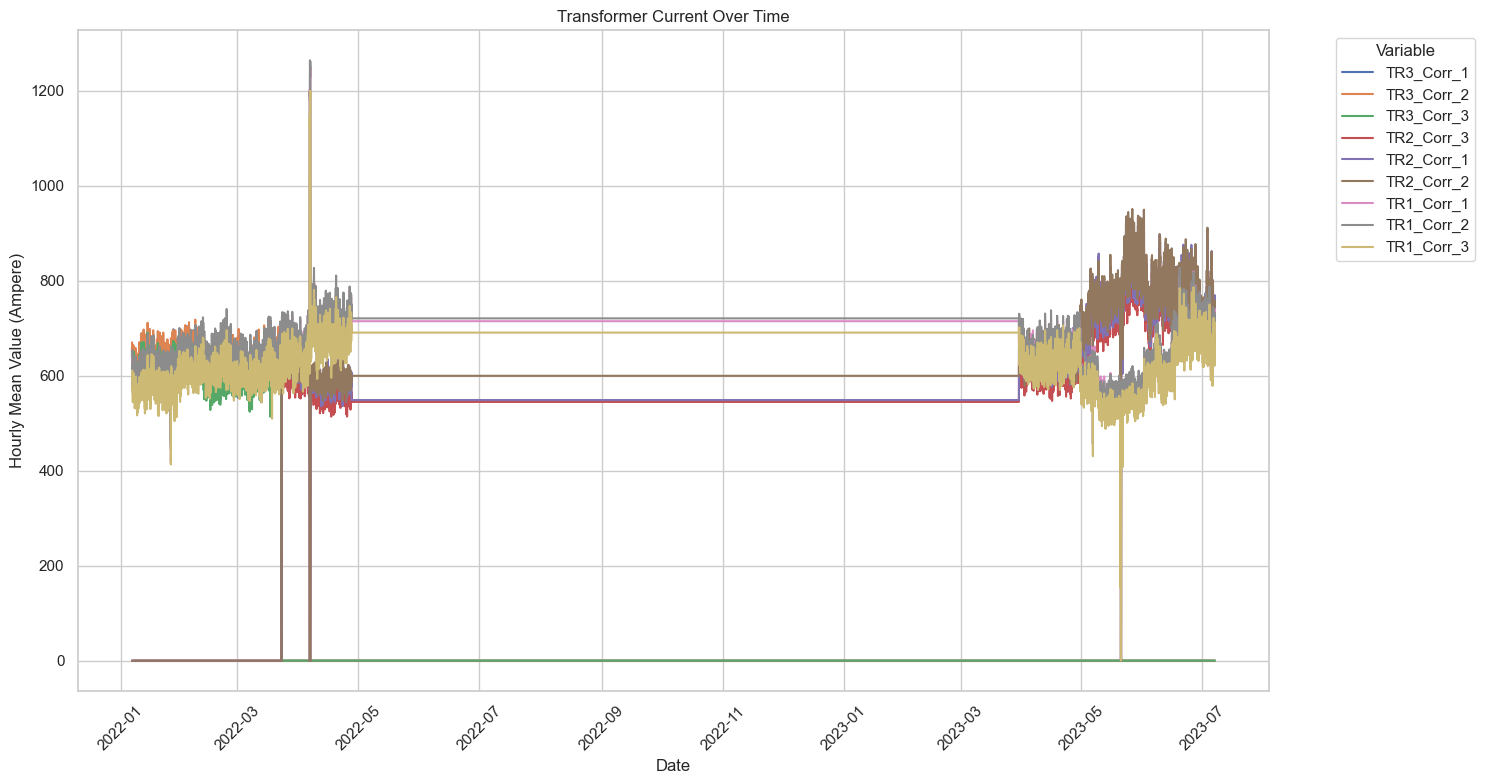

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Plotting the mean value for each variable per day
plt.figure(figsize=(15, 8))

variables = data_hourly_mean['Variable'].unique()

corr123_variables = [var for var in variables if var.startswith('TR') and 'Corr' in var and not var.endswith('N')]
for variable in corr123_variables:
    subset = data_hourly_mean[data_hourly_mean['Variable'] == variable]
    plt.plot(subset['Date'], subset['Value'], label=variable)

plt.xlabel('Date')
plt.ylabel('Hourly Mean Value (Ampere)')
plt.title('Transformer Current Over Time')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

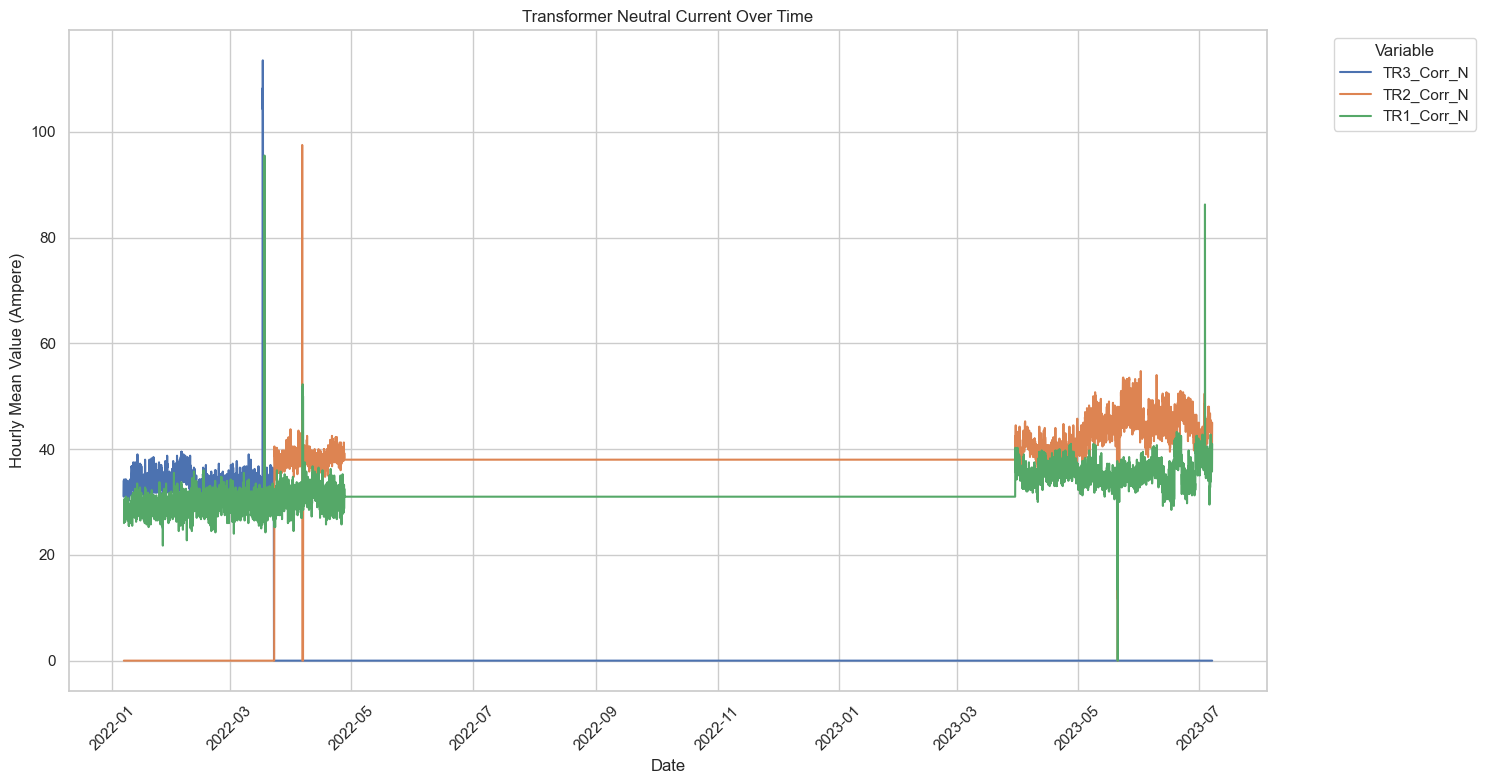

In [9]:
# Plotting the mean value for each variable per day
plt.figure(figsize=(15, 8))

trN_variables = [var for var in variables if var.startswith('TR') and var.endswith('N')]
for variable in trN_variables:
    subset = data_hourly_mean[data_hourly_mean['Variable'] == variable]
    plt.plot(subset['Date'], subset['Value'], label=variable)

plt.xlabel('Date')
plt.ylabel('Hourly Mean Value (Ampere)')
plt.title('Transformer Neutral Current Over Time')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

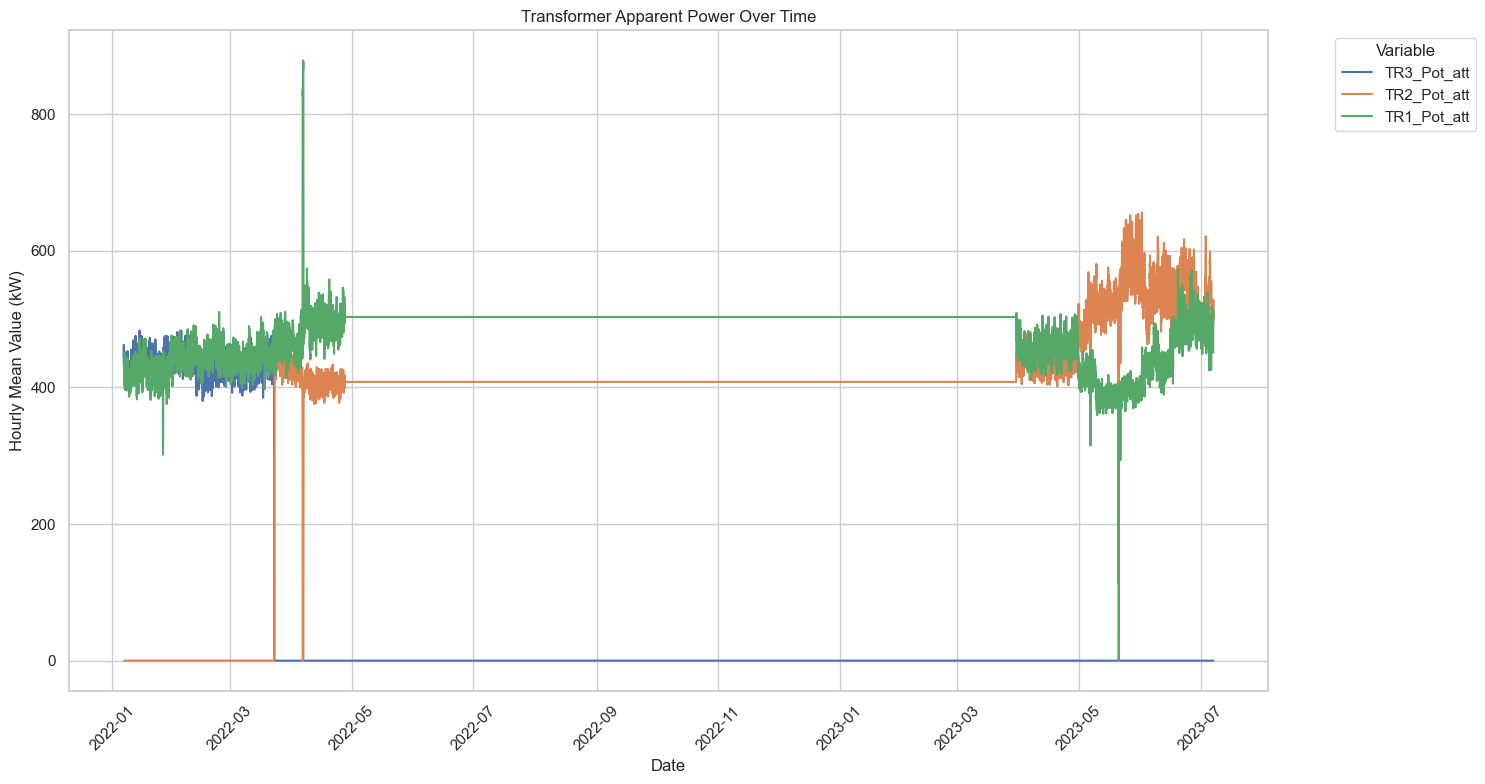

In [10]:
# Plotting the mean value for each variable per day
plt.figure(figsize=(15, 8))

pot_variables = [var for var in variables if 'Pot_att' in var]
for variable in pot_variables:
    subset = data_hourly_mean[data_hourly_mean['Variable'] == variable]
    plt.plot(subset['Date'], subset['Value'], label=variable)

plt.xlabel('Date')
plt.ylabel('Hourly Mean Value (kW)')
plt.title('Transformer Apparent Power Over Time')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

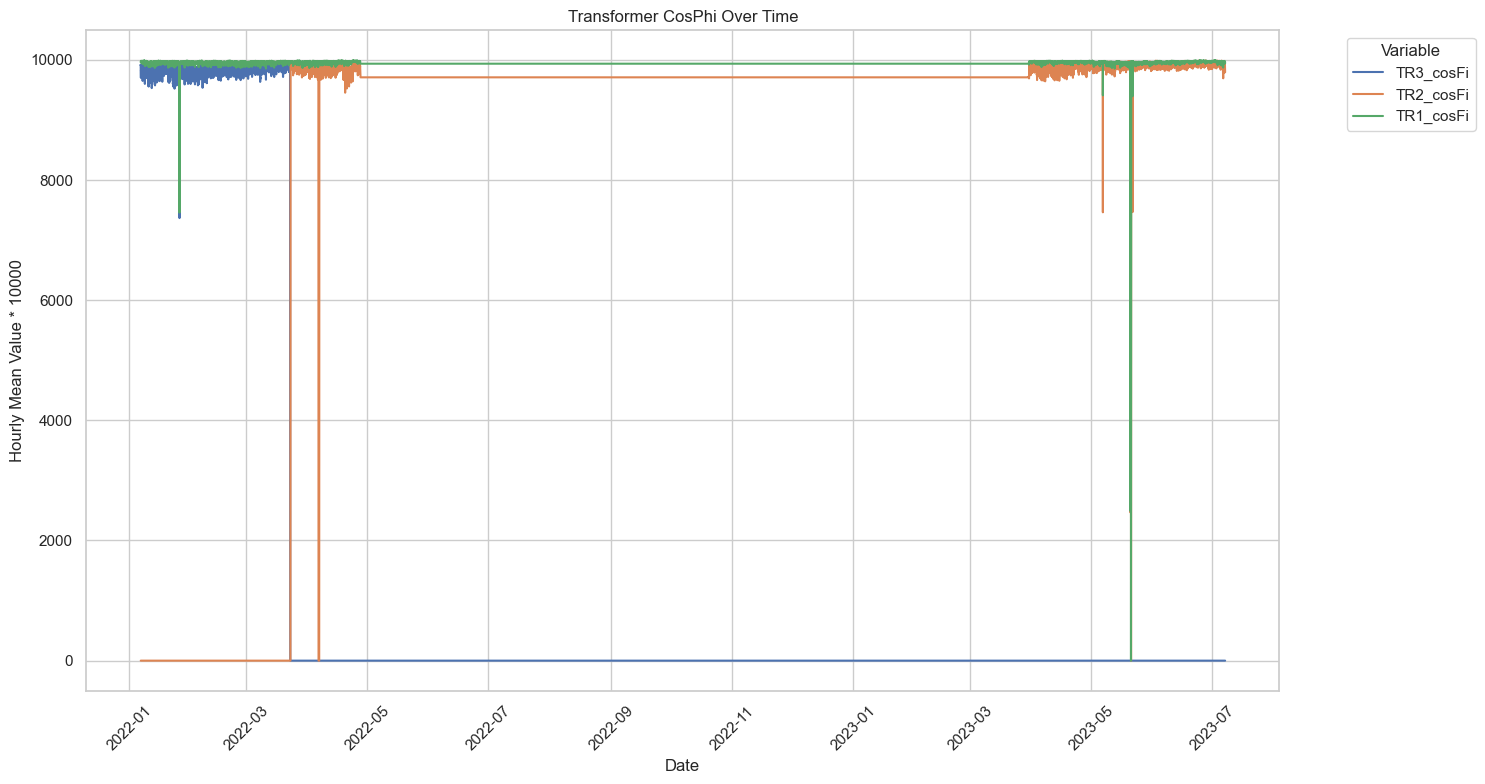

In [11]:
# Plotting the mean value for each variable per day
plt.figure(figsize=(15, 8))

cosfi = [var for var in variables if var.endswith('cosFi')]
for variable in cosfi:
    subset = data_hourly_mean[data_hourly_mean['Variable'] == variable]
    plt.plot(subset['Date'], subset['Value'], label=variable)

plt.xlabel('Date')
plt.ylabel('Hourly Mean Value * 10000')
plt.title('Transformer CosPhi Over Time')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

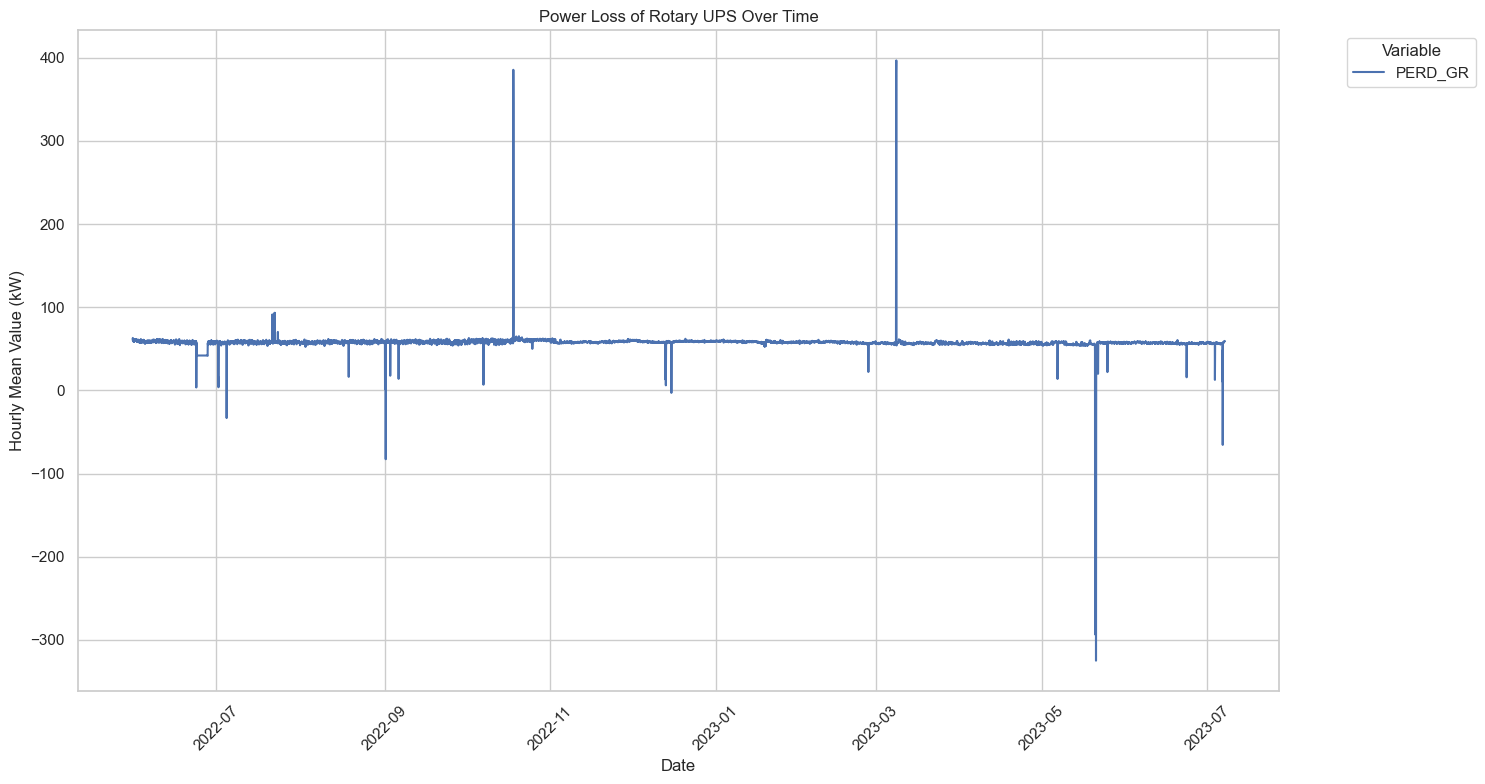

In [12]:
# Plotting the mean value for each variable per day
plt.figure(figsize=(15, 8))

perd_gr = data_hourly_mean[data_hourly_mean['Variable'] == 'PERD_GR']
plt.plot(perd_gr['Date'], perd_gr['Value'], label='PERD_GR')

plt.xlabel('Date')
plt.ylabel('Hourly Mean Value (kW)')
plt.title('Power Loss of Rotary UPS Over Time')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

We can drop the following variable, since it's the sum of other variables in the dataset and there's only data for it for 2 months

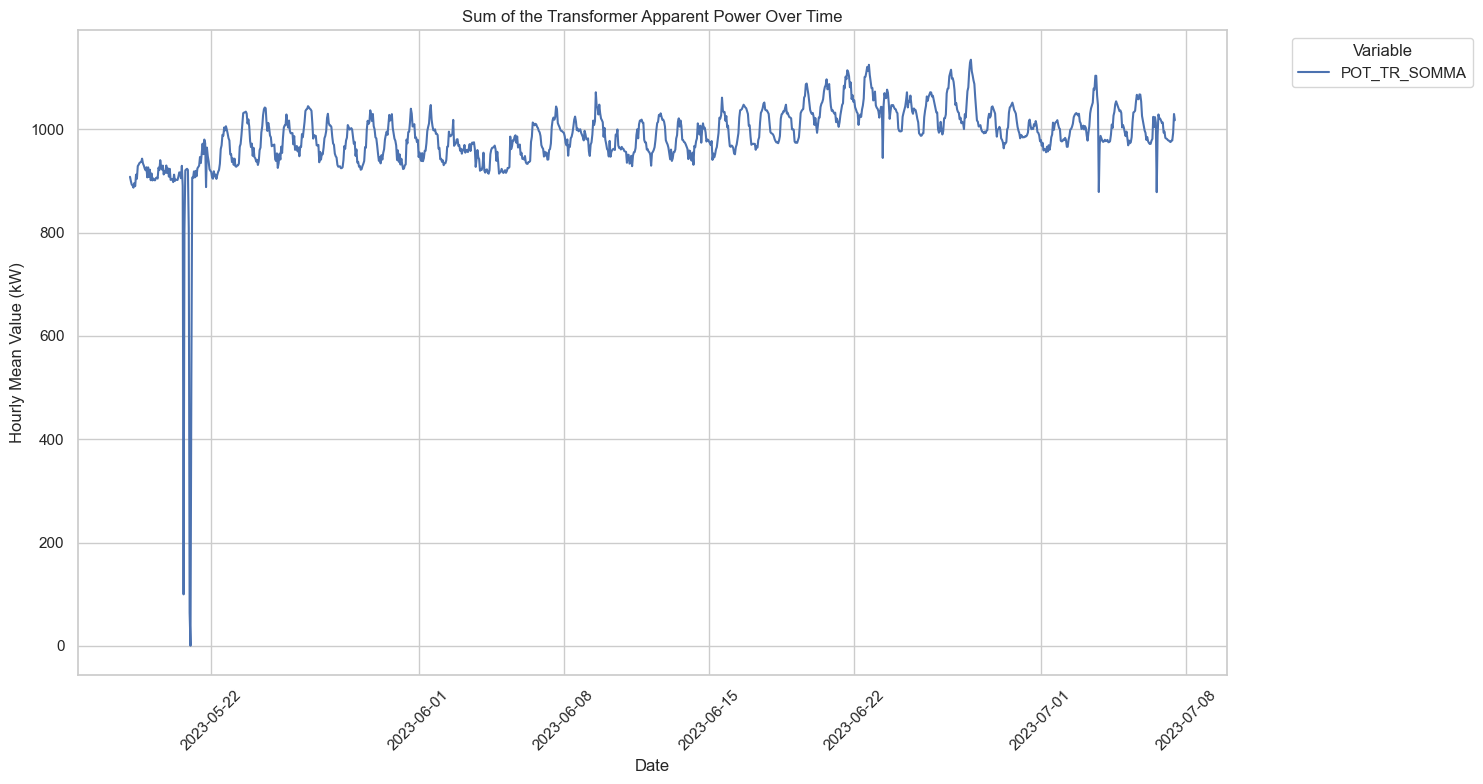

In [13]:
# Plotting the mean value for each variable per day
plt.figure(figsize=(15, 8))

somma = data_hourly_mean[data_hourly_mean['Variable'] == 'POT_TR_SOMMA']
plt.plot(somma['Date'], somma['Value'], label='POT_TR_SOMMA')

plt.xlabel('Date')
plt.ylabel('Hourly Mean Value (kW)')
plt.title('Sum of the Transformer Apparent Power Over Time')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

Standardize selected variables

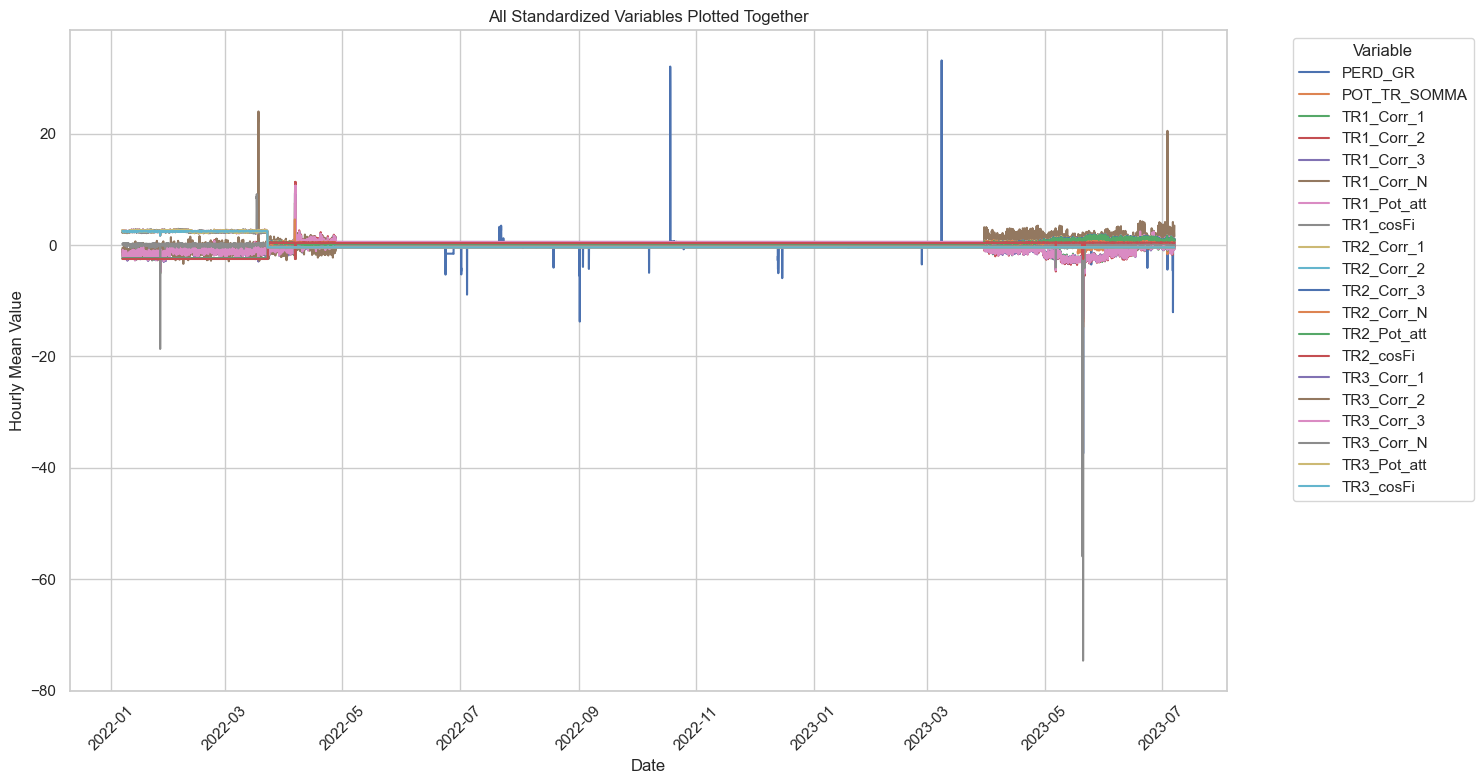

In [14]:
from sklearn.preprocessing import StandardScaler

# Grouping the data by 'Variable'
grouped_data = data_hourly_mean.groupby('Variable')

# Initializing an empty dataframe to hold the standardized data
standardized_data = pd.DataFrame()

scaler = StandardScaler()

# Standardizing the 'Value' for each group
for name, group in grouped_data:
    group['Standardized Value'] = scaler.fit_transform(group[['Value']])
    standardized_data = pd.concat([standardized_data, group])

standardized_data

# Plotting the mean value for each variable per day
plt.figure(figsize=(15, 8))

variables = standardized_data['Variable'].unique()

for variable in variables:
    subset = standardized_data[standardized_data['Variable'] == variable]
    plt.plot(subset['Date'], subset['Standardized Value'], label=variable)

plt.xlabel('Date')
plt.ylabel('Hourly Mean Value')
plt.title('All Standardized Variables Plotted Together')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

Reshape the dataset from long to wide format

In [15]:
wide_standardized = standardized_data.pivot(index='Date', columns='Variable', values='Standardized Value').reset_index()

wide_standardized

Variable,Date,PERD_GR,POT_TR_SOMMA,TR1_Corr_1,TR1_Corr_2,TR1_Corr_3,TR1_Corr_N,TR1_Pot_att,TR1_cosFi,TR2_Corr_1,...,TR2_Corr_3,TR2_Corr_N,TR2_Pot_att,TR2_cosFi,TR3_Corr_1,TR3_Corr_2,TR3_Corr_3,TR3_Corr_N,TR3_Pot_att,TR3_cosFi
0,2022-01-06 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.495217,NaN
1,2022-01-06 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.576344,2.585682,2.535912,2.465709,2.688412,2.526164
2,2022-01-06 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.355288,NaN,NaN,NaN,2.606570,2.548222,2.549049,2.213179,2.566482,2.525574
3,2022-01-06 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.335813,...,-2.355288,-2.441477,-2.385681,NaN,2.644933,2.644711,2.563381,2.318400,2.604898,2.526459
4,2022-01-06 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,-2.071704,NaN,-2.335813,...,-2.355288,-2.441477,-2.385681,-2.486445,2.540305,2.460814,2.501276,2.381533,2.498001,2.509342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13117,2023-07-07 07:00:00,0.102129,-0.146606,-0.582848,-0.766520,-0.415053,1.528121,-0.628516,0.152799,1.009356,...,1.004911,0.600657,0.894755,0.435150,-0.399751,-0.399795,-0.399729,-0.396297,-0.399918,-0.400139
13118,2023-07-07 08:00:00,0.124303,-0.136915,0.076645,-0.143313,0.324266,1.528121,0.005408,0.141539,0.947281,...,0.981330,0.546333,0.828533,0.448840,-0.399751,-0.399795,-0.399729,-0.396297,-0.399918,-0.400139
13119,2023-07-07 09:00:00,0.185931,0.079673,-0.000376,-0.392596,0.430573,2.845398,0.005408,0.186582,1.203629,...,1.171152,0.781736,1.027200,0.436852,-0.399751,-0.399795,-0.399729,-0.396297,-0.399918,-0.400139
13120,2023-07-07 10:00:00,0.173866,0.626307,1.058663,0.769062,0.991102,3.504036,0.855135,-0.001098,1.030048,...,0.974256,0.817952,0.816688,0.412284,-0.399751,-0.399795,-0.399729,-0.396297,-0.399918,-0.400139


Correlation matrix of all variables except the removed one

In [28]:
wide_standardized_nosomma = wide_standardized.drop('POT_TR_SOMMA', axis=1)

# Specify numeric_only=True to compute correlation between numeric columns
correlation_matrix = wide_standardized_nosomma.corr(numeric_only=True)
correlation_matrix


Variable,PERD_GR,TR1_Corr_1,TR1_Corr_2,TR1_Corr_3,TR1_Corr_N,TR1_Pot_att,TR1_cosFi,TR2_Corr_1,TR2_Corr_2,TR2_Corr_3,TR2_Corr_N,TR2_Pot_att,TR2_cosFi,TR3_Corr_1,TR3_Corr_2,TR3_Corr_3,TR3_Corr_N,TR3_Pot_att,TR3_cosFi
Variable,,,,,,,,,,,,,,,,,,,
PERD_GR,1.000000,0.204516,0.203563,0.199502,0.039750,0.199582,0.606223,0.009874,0.034966,0.017314,0.083918,0.031942,0.512093,NaN,NaN,NaN,NaN,NaN,NaN
TR1_Corr_1,0.204516,1.000000,0.989987,0.994089,-0.082335,0.994597,0.146552,0.261628,0.319653,0.282544,0.385396,0.314352,0.478942,-0.505966,-0.505742,-0.505712,-0.499163,-0.505589,-0.506621
TR1_Corr_2,0.203563,0.989987,1.000000,0.989138,-0.114961,0.992625,0.156895,0.192808,0.250448,0.213315,0.315276,0.244714,0.412643,-0.440624,-0.439988,-0.440063,-0.433871,-0.439884,-0.440725
TR1_Corr_3,0.199502,0.994089,0.989138,1.000000,-0.099585,0.995669,0.138930,0.256140,0.315376,0.278196,0.380655,0.310114,0.473698,-0.500478,-0.500042,-0.499885,-0.493591,-0.499858,-0.500953
TR1_Corr_N,0.039750,-0.082335,-0.114961,-0.099585,1.000000,-0.106705,0.167257,0.459623,0.416496,0.445000,0.373626,0.420922,0.292917,-0.290117,-0.289745,-0.289985,-0.285040,-0.289985,-0.292042
TR1_Pot_att,0.199582,0.994597,0.992625,0.995669,-0.106705,1.000000,0.142618,0.233823,0.293449,0.255493,0.360092,0.287868,0.456301,-0.483749,-0.483338,-0.483294,-0.476913,-0.483274,-0.484328
TR1_cosFi,0.606223,0.146552,0.156895,0.138930,0.167257,0.142618,1.000000,0.024938,0.019136,0.022508,0.015724,0.019892,0.011347,0.031515,0.031345,0.031320,0.030484,0.031621,0.032173
TR2_Corr_1,0.009874,0.261628,0.192808,0.256140,0.459623,0.233823,0.024938,1.000000,0.995538,0.999045,0.982013,0.996338,0.945874,-0.933227,-0.933330,-0.933175,-0.925159,-0.933359,-0.934133
TR2_Corr_2,0.034966,0.319653,0.250448,0.315376,0.416496,0.293449,0.019136,0.995538,1.000000,0.998040,0.992386,0.999680,0.966668,-0.955752,-0.955858,-0.955699,-0.947490,-0.955888,-0.956680


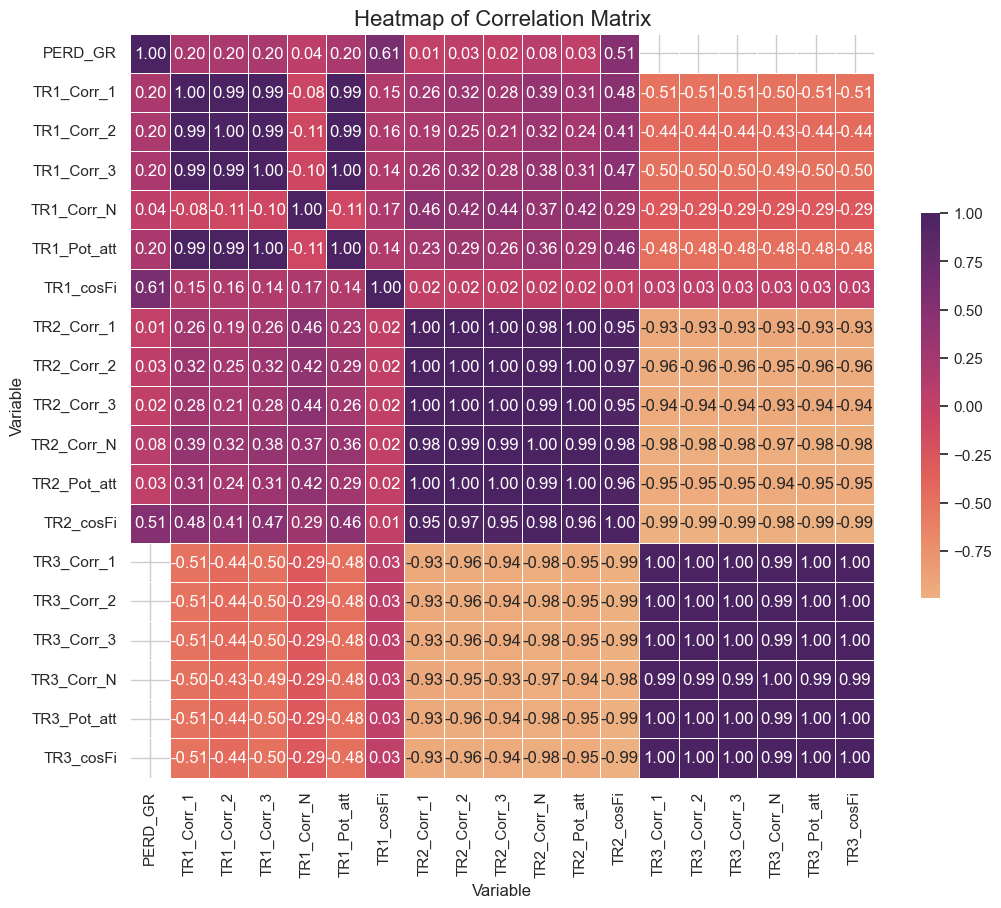

In [33]:
# Create a heatmap with blue tones for the loaded correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='flare', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Heatmap of Correlation Matrix", fontsize=16)
plt.show()


Group highly correlated variables together by summing them up

In [17]:
# Since they're all highly positively correlated to their transformer's corresponding Pot_Att, remove all TRX_Corr_X variables

wide_standardized_10vars = wide_standardized_nosomma.drop(corr123_variables, axis=1)

wide_standardized_10vars.head()

Variable,Date,PERD_GR,TR1_Corr_N,TR1_Pot_att,TR1_cosFi,TR2_Corr_N,TR2_Pot_att,TR2_cosFi,TR3_Corr_N,TR3_Pot_att,TR3_cosFi
0,2022-01-06 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.495217,NaN
1,2022-01-06 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.465709,2.688412,2.526164
2,2022-01-06 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.213179,2.566482,2.525574
3,2022-01-06 19:00:00,NaN,NaN,NaN,NaN,-2.441477,-2.385681,NaN,2.318400,2.604898,2.526459
4,2022-01-06 20:00:00,NaN,NaN,-2.071704,NaN,-2.441477,-2.385681,-2.486445,2.381533,2.498001,2.509342


Impute missing values in PERD_GR using predictive imputation after taking the sum of the TR2 and TR3 variables (so the imputer does not go crazy)

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

wide_standardized_noNA = wide_standardized_10vars.copy()

imputation_df = wide_standardized_10vars.drop('Date', axis=1)

imputation_df['TR2_TR3_Corr_N'] = imputation_df['TR2_Corr_N'] + imputation_df['TR3_Corr_N']
imputation_df['TR2_TR3_Pot_att'] = imputation_df['TR2_Pot_att'] + imputation_df['TR3_Pot_att']
imputation_df['TR2_TR3_cosFi'] = imputation_df['TR2_cosFi'] + imputation_df['TR3_cosFi']
imputation_df.drop(['TR2_Corr_N','TR3_Corr_N','TR2_Pot_att','TR3_Pot_att','TR2_cosFi','TR3_cosFi'], axis=1, inplace=True)

numeric_columns = imputation_df.select_dtypes(include=['number']).columns
imputation_df_scaled = imputation_df
imputation_df_scaled[numeric_columns] = scaler.fit_transform(imputation_df[numeric_columns])

imputer = IterativeImputer(random_state=123)
imputation_df_scaled[numeric_columns] = imputer.fit_transform(imputation_df_scaled[numeric_columns])

imputation_df_scaled[numeric_columns] = scaler.fit_transform(imputation_df_scaled[numeric_columns])

wide_standardized_noNA['PERD_GR'] = imputation_df_scaled['PERD_GR']

# Drop 6 rows for which theres not info for all variables (first 5 and last observation in chronological order)
wide_standardized_noNA = wide_standardized_noNA.dropna(axis=0)

wide_standardized_noNA

Variable,Date,PERD_GR,TR1_Corr_N,TR1_Pot_att,TR1_cosFi,TR2_Corr_N,TR2_Pot_att,TR2_cosFi,TR3_Corr_N,TR3_Pot_att,TR3_cosFi
5,2022-01-06 21:00:00,0.325737,-2.141435,-1.511963,0.257900,-2.441477,-2.385681,-2.486445,2.486754,2.639974,2.497832
6,2022-01-06 22:00:00,-0.055789,-0.447794,-0.837576,0.085235,-2.441477,-2.385681,-2.486445,2.402577,2.513033,2.462639
7,2022-01-06 23:00:00,0.230586,-1.294615,-1.039892,0.310450,-2.441477,-2.385681,-2.486445,2.276312,2.534747,2.501964
8,2022-01-07 00:00:00,0.073282,-0.730068,-1.606377,0.248516,-2.441477,-2.385681,-2.486445,2.297356,2.568152,2.494586
9,2022-01-07 01:00:00,0.261105,-1.953253,-1.417549,0.216610,-2.441477,-2.385681,-2.486445,2.465709,2.586525,2.486839
...,...,...,...,...,...,...,...,...,...,...,...
13116,2023-07-07 06:00:00,0.107956,1.716303,-0.837576,0.042069,0.600657,0.935135,0.453502,-0.396297,-0.399918,-0.400139
13117,2023-07-07 07:00:00,0.087578,1.528121,-0.628516,0.152799,0.600657,0.894755,0.435150,-0.396297,-0.399918,-0.400139
13118,2023-07-07 08:00:00,0.111889,1.528121,0.005408,0.141539,0.546333,0.828533,0.448840,-0.396297,-0.399918,-0.400139
13119,2023-07-07 09:00:00,0.179459,2.845398,0.005408,0.186582,0.781736,1.027200,0.436852,-0.396297,-0.399918,-0.400139


In [23]:
wide_standardized_noNA.to_csv(os.path.join('..','results','dataset_with_noNA.csv'), index=False)

corr_mat = wide_standardized_noNA.corr(numeric_only=True)
corr_mat

Variable,PERD_GR,TR1_Corr_N,TR1_Pot_att,TR1_cosFi,TR2_Corr_N,TR2_Pot_att,TR2_cosFi,TR3_Corr_N,TR3_Pot_att,TR3_cosFi
Variable,,,,,,,,,,
PERD_GR,1.000000,-0.074903,0.064142,0.582660,0.002651,-0.004453,0.012454,0.045775,0.040440,0.041769
TR1_Corr_N,-0.074903,1.000000,-0.106705,0.167257,0.373626,0.420922,0.292917,-0.285040,-0.289985,-0.292042
TR1_Pot_att,0.064142,-0.106705,1.000000,0.142618,0.359846,0.287601,0.456090,-0.476718,-0.483074,-0.484127
TR1_cosFi,0.582660,0.167257,0.142618,1.000000,0.015724,0.019892,0.011347,0.030484,0.031621,0.032173
TR2_Corr_N,0.002651,0.373626,0.359846,0.015724,1.000000,0.991583,0.984628,-0.966982,-0.975559,-0.976368
TR2_Pot_att,-0.004453,0.420922,0.287601,0.019892,0.991583,1.000000,0.964266,-0.944864,-0.953245,-0.954035
TR2_cosFi,0.012454,0.292917,0.456090,0.011347,0.984628,0.964266,1.000000,-0.984539,-0.993272,-0.994095
TR3_Corr_N,0.045775,-0.285040,-0.476718,0.030484,-0.966982,-0.944864,-0.984539,1.000000,0.989689,0.990184
TR3_Pot_att,0.040440,-0.289985,-0.483074,0.031621,-0.975559,-0.953245,-0.993272,0.989689,1.000000,0.999051


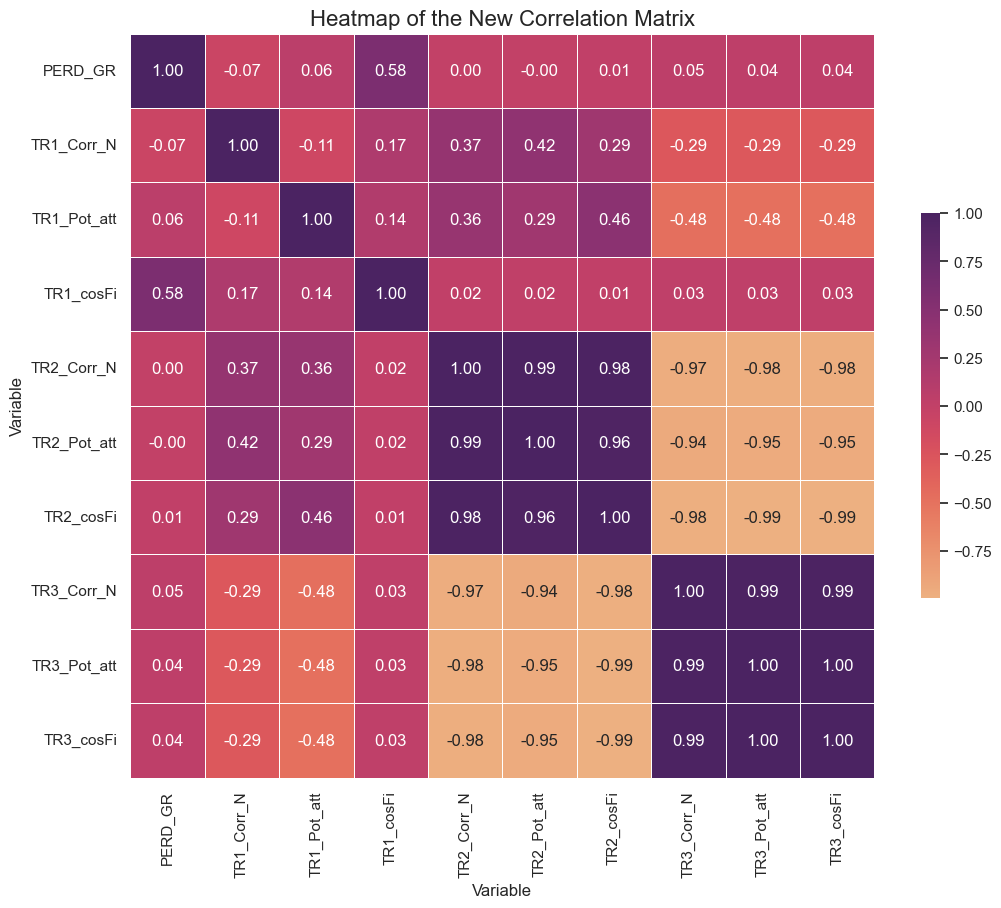

In [34]:
# Create a heatmap with blue tones for the loaded correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_mat, annot=True, fmt='.2f', cmap='flare', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Heatmap of the New Correlation Matrix", fontsize=16)
plt.show()

Identify data variation with respect to the median value

In [24]:
# Calculating the median value for each standardized variable
medians_standardized = wide_standardized_noNA.median(numeric_only=True).reset_index().rename(columns={0: 'Median'})

medians_standardized.head()

,Variable,Median
0,PERD_GR,0.023319
1,TR1_Corr_N,-0.259612
2,TR1_Pot_att,0.571893
3,TR1_cosFi,-0.042387
4,TR2_Corr_N,0.310930
